In [1]:
%run ../scripts/notebook_settings.py
import sgkit as sg
import xarray as xr
import glob

from skbio import DistanceMatrix
from skbio.tree import nj
from skbio.tree import upgma
from skbio.tree import bme

import baltic as bt

In [2]:
# Functions

def read_beds(long_form, bed_base):
    bed_path_x = bed_base+"{}/filteredVCF/all_samples/pos_bed_cov_based/{}_batch*_fploidy2_mploidy1.bed".format(long_form, long_form)
    bed_path_all = bed_base+"{}/filteredVCF/all_samples/pos_bed_cov_based/{}_batch*_fploidy2_mploidy2.bed".format(long_form, long_form)
    bed_l = []
    for b in glob.glob(bed_path_all):
        bed_file = pd.read_csv(b, sep="\t", names=["chrom", "start", "end"])
        bed_l.append(bed_file)
    bed_files = pd.concat(bed_l)
    bed_l = []
    for b in glob.glob(bed_path_x):
        #print(b)
        bed_file = pd.read_csv(b, sep="\t", names=["chrom", "start", "end"])
        bed_l.append(bed_file)
    if len(bed_l) > 0:
        bed_x = pd.concat(bed_l)
        bed_files = bed_files.loc[~(bed_files.chrom.isin(bed_x.chrom.unique()))]
        bed_files = pd.concat([bed_files, bed_x]).sort_values(by=["chrom", "start", "end"])
    return bed_files


def pos_windows(bed_l, window_size, chrom_order):
    # Input a bed file and the window size of intervals desired. Multiple chromosomes accepted.
    # It has to be sorted.
    df_l = []
    for c in chrom_order:
        #print(c)
        frac_l = []
        b = bed_l.loc[bed_l["chrom"] == c].copy()
        b["w_s"] = b.end-b.start
        w_start = b.start.iloc[0]
        current_pos, callable_bases = 0, 0
        for i, j, k in zip(b.start, b.end, b.w_s):
            # Nothing called in the current window under investigation.
            while i-window_size >= current_pos:
                frac_l.append(callable_bases/window_size)
                callable_bases = 0
                current_pos += window_size
            # Window starts in current. We know this is true because of the previous while loop.
            callable_bases += min(k, current_pos+window_size-i)
            # Everything called in current.
            while j-window_size >= current_pos:
                frac_l.append(callable_bases/window_size)
                callable_bases = 0
                current_pos += window_size
                if j-window_size >= current_pos:
                    callable_bases += window_size
                else:
                # Window stops in current. Again, know this is true.
                    callable_bases += j-current_pos
        # Last window.
        frac_l.append(callable_bases/(window_size))
        df_l.append(pd.DataFrame({"chrom": c, "window_start": list(range(0, len(frac_l)*window_size, window_size)),
                                  "window_end": list(range(window_size, (len(frac_l)+1)*window_size, window_size)),
                                  "callable_frac": frac_l}))
    return pd.concat(df_l)

In [3]:
table_desc = "~/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/plots/SupTable_Sample_Stats_wGT_QC.tsv"
metadata_path = "~/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"

metadata_table = pd.read_csv(table_desc, sep="\t")

metadata_20x_filt = metadata_table.loc[(metadata_table.finalQC != "fail")
                              & (metadata_table.cov_chrA >= 20)
                              & (metadata_table.remove_as_relative != True)
                              & (metadata_table.remove_manual != True)
                              & (~metadata_table.ID.str.startswith("SAMEA11633"))
                             ]

First checking up on Macaca Arctoides which I know has some oddities, then expanding to check all other species.

In [4]:
print("Loading metadata")
zarr_path = "../zarr_20x_inds/Macaca_arctoides_ssp/zarr"
metadata_path = "~/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"
bed_base = "~/primatediversity/data/gVCFs_recalling_10_12_2024/"

short_form = zarr_path.split("/")[-2].split("_")[0]
long_form = zarr_path.split("/")[-2]
# Loading the various metadata files. Metadata, contig information, callability bed.
metadata_df = pd.read_csv(metadata_path+"{}_individuals.txt".format(short_form), sep="\t")
metadata_df["SEX_I"] = [0 if x == "F" else 1 for x in metadata_df.GENETIC_SEX]
regions_df = pd.read_csv(metadata_path+"{}_regions_and_batches.txt".format(short_form), sep="\t")
regions_df["LENGTH"] = regions_df["END"]-regions_df["START"]
regions_df["chr_type"] = ["chrX" if x == 2 and y == 1 else "aut" for x, y in zip(regions_df.FEMALE_PLOIDY, regions_df.MALE_PLOIDY)]
large_contigs = regions_df.loc[(regions_df.LENGTH >= 1000000) & (regions_df.FEMALE_PLOIDY == 2)].CONTIG_ID.unique()
large_aut = regions_df.loc[(regions_df.LENGTH >= 1000000) & (regions_df.FEMALE_PLOIDY == 2) &
                        (regions_df.MALE_PLOIDY == 2)].CONTIG_ID
large_x = regions_df.loc[(regions_df.LENGTH >= 1000000) & (regions_df.FEMALE_PLOIDY == 2) &
                        (regions_df.MALE_PLOIDY == 1)].CONTIG_ID
print("Loading bed files")
bed_files = read_beds(long_form, os.path.expanduser(bed_base))
# Loading the genetic data.
print("Loading genetic data")
df_l = []
ds_full = sg.load_dataset(zarr_path)
kept_contigs =  [x for x in ds_full.contig_id.values if (x == large_contigs).any()]
contig_IDs = pd.Series(kept_contigs).map(dict(zip(ds_full.contig_id.values, range(len(ds_full.contig_id.values))))).values

Loading metadata
Loading bed files
Loading genetic data


In [5]:
# Keeping it restricted to two chromosomes for the first investigation.
large_aut_sel = regions_df.loc[regions_df.CONTIG_ID.isin(ds_full.contig_id.values)].CONTIG_ID[2:4]
large_aut_sel

3310    NC_065580.1
3311    NC_065581.1
Name: CONTIG_ID, dtype: object

In [6]:
kept_contigs =  [x for x in ds_full.contig_id.values if (x == large_aut_sel).any()]
contig_IDs = pd.Series(kept_contigs).map(dict(zip(ds_full.contig_id.values, range(len(ds_full.contig_id.values))))).values
ds_filt = ds_full.sel(variants=(ds_full.variant_contig.isin(contig_IDs).compute()), contigs=contig_IDs)
ds_filt["sample_cohort"] = ds_filt["samples"]
ds_filt

<xarray.Dataset> Size: 274MB
Dimensions:               (variants: 3384495, samples: 8, ploidy: 2,
                           contigs: 2, filters: 2, region_index_values: 46,
                           region_index_fields: 6, alt_alleles: 1, alleles: 2)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alt_alleles, alleles
Data variables: (12/20)
    call_genotype         (variants, samples, ploidy) int8 54MB dask.array<chunksize=(984875, 8, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 54MB dask.array<chunksize=(984875, 8, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 27MB dask.array<chunksize=(984875, 8), meta=np.ndarray>
    contig_id             (contigs) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    contig_length         (contigs) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    filter_description    (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_id            (variants) object 27MB dask.array<chunksize=(984875,), meta=np.ndarray>
    variant_id_mask       (variants) bool 3MB dask.array<chunksize=(984875,), meta=np.ndarray>
    variant_length        (variants) int16 7MB dask.array<chunksize=(984875,), meta=np.ndarray>
    variant_position      (variants) int32 14MB dask.array<chunksize=(984875,), meta=np.ndarray>
    variant_quality       (variants) float32 14MB dask.array<chunksize=(984875,), meta=np.ndarray>
    sample_cohort         (samples) int64 64B 0 1 2 3 4 5 6 7
Attributes:
    source:                bio2zarr-0.1.6
    vcf_meta_information:  [['fileformat', 'VCFv4.2'], ['ALT', '<ID=NON_REF,D...
    vcf_zarr_version:      0.4

In [7]:
kept_contigs_x =  [x for x in ds_full.contig_id.values if (x == large_x).any()]
contig_IDs = pd.Series(kept_contigs_x).map(dict(zip(ds_full.contig_id.values, range(len(ds_full.contig_id.values))))).values
ds_filt_x = ds_full.sel(variants=(ds_full.variant_contig.isin(contig_IDs).compute()), contigs=contig_IDs)
ds_filt_x["sample_cohort"] = ds_filt_x["samples"]
ds_filt_x

<xarray.Dataset> Size: 61MB
Dimensions:               (variants: 748734, samples: 8, ploidy: 2, contigs: 1,
                           filters: 2, region_index_values: 46,
                           region_index_fields: 6, alt_alleles: 1, alleles: 2)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alt_alleles, alleles
Data variables: (12/20)
    call_genotype         (variants, samples, ploidy) int8 12MB dask.array<chunksize=(748734, 8, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 12MB dask.array<chunksize=(748734, 8, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 6MB dask.array<chunksize=(748734, 8), meta=np.ndarray>
    contig_id             (contigs) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    contig_length         (contigs) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    filter_description    (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_id            (variants) object 6MB dask.array<chunksize=(748734,), meta=np.ndarray>
    variant_id_mask       (variants) bool 749kB dask.array<chunksize=(748734,), meta=np.ndarray>
    variant_length        (variants) int16 1MB dask.array<chunksize=(748734,), meta=np.ndarray>
    variant_position      (variants) int32 3MB dask.array<chunksize=(748734,), meta=np.ndarray>
    variant_quality       (variants) float32 3MB dask.array<chunksize=(748734,), meta=np.ndarray>
    sample_cohort         (samples) int64 64B 0 1 2 3 4 5 6 7
Attributes:
    source:                bio2zarr-0.1.6
    vcf_meta_information:  [['fileformat', 'VCFv4.2'], ['ALT', '<ID=NON_REF,D...
    vcf_zarr_version:      0.4

In [8]:
# Calculating divergence between all sites.
# Note that 0 means same state, 0.5 means homozygous to heterozygous, and 1 means homozygous to alternate homozygous
# nan if one/both of the inds are missing at that position.
div_calc = sg.divergence(ds_filt)
value_matrix = div_calc.stat_divergence.values
value_matrix

array([[[0. , nan, 0. , ..., 0. , nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [0. , nan, 0. , ..., 0. , nan, nan],
        ...,
        [0. , nan, 0. , ..., 0. , nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[0. , nan, 0. , ..., 0. , nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [0. , nan, 0. , ..., 0. , nan, nan],
        ...,
        [0. , nan, 0. , ..., 0. , nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[0. , nan, 0. , ..., 0. , nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [0. , nan, 0. , ..., 0. , nan, nan],
        ...,
        [0. , nan, 0. , ..., 0. , nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, 0. , nan, ..., nan, 0.5, 1. ],
        [nan, nan, nan, ..., nan, nan, nan

In [9]:
#Calculate total cover from the selected chromosomes and then summing the number of differences
bed_select = bed_files.loc[bed_files.chrom.isin(large_aut_sel)]
total_cover = bed_select.end.sum()-bed_select.start.sum()

input_df = pd.DataFrame(np.nansum(value_matrix, axis=0)/total_cover, columns = ds_filt.sample_id.values)
input_df

,PD_0071,PD_0533,PD_0535,SAMN04316319,SAMN14521207,SAMN15194901,SAMN15194902,SAMN19736176
0,0.001033,0.001747,0.001716,0.001876,0.001089,0.001884,0.003005,0.002902
1,0.001747,0.001154,0.001041,0.001860,0.001633,0.001849,0.002980,0.002885
2,0.001716,0.001041,0.000740,0.001845,0.001607,0.001848,0.002964,0.002855
3,0.001876,0.001860,0.001845,0.001840,0.001787,0.001786,0.002964,0.002866
4,0.001089,0.001633,0.001607,0.001787,0.000895,0.001793,0.002821,0.002755
5,0.001884,0.001849,0.001848,0.001786,0.001793,0.001704,0.002963,0.002870
6,0.003005,0.002980,0.002964,0.002964,0.002821,0.002963,0.001174,0.001132
7,0.002902,0.002885,0.002855,0.002866,0.002755,0.002870,0.001132,0.001119


In [10]:
norm_diff_matrix = (np.nansum((value_matrix), axis=0)/total_cover)
np.fill_diagonal(norm_diff_matrix, 0)
norm_diff_matrix

array([[0.        , 0.00174659, 0.00171606, 0.0018763 , 0.00108932,
        0.00188436, 0.00300504, 0.00290173],
       [0.00174659, 0.        , 0.00104087, 0.00186009, 0.00163301,
        0.00184944, 0.00298017, 0.00288497],
       [0.00171606, 0.00104087, 0.        , 0.00184516, 0.00160711,
        0.00184841, 0.00296363, 0.00285519],
       [0.0018763 , 0.00186009, 0.00184516, 0.        , 0.00178684,
        0.00178618, 0.0029642 , 0.00286575],
       [0.00108932, 0.00163301, 0.00160711, 0.00178684, 0.        ,
        0.00179274, 0.00282134, 0.00275496],
       [0.00188436, 0.00184944, 0.00184841, 0.00178618, 0.00179274,
        0.        , 0.0029629 , 0.00287039],
       [0.00300504, 0.00298017, 0.00296363, 0.0029642 , 0.00282134,
        0.0029629 , 0.        , 0.00113234],
       [0.00290173, 0.00288497, 0.00285519, 0.00286575, 0.00275496,
        0.00287039, 0.00113234, 0.        ]])

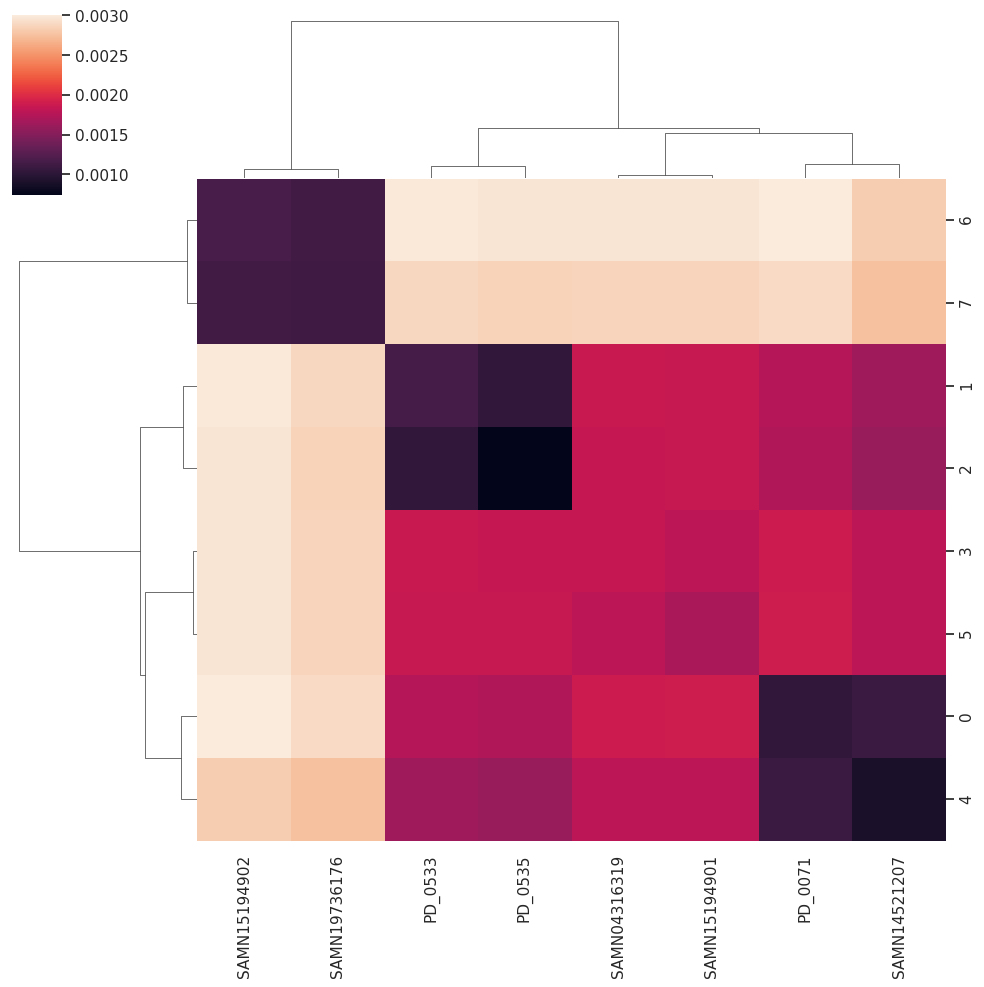

In [30]:
sns.clustermap(input_df)

In [11]:
dm = DistanceMatrix(norm_diff_matrix, ds_filt.sample_id.values)
set_list = []

In [27]:
tree = nj(dm).root_at_midpoint()
for node in tree.preorder():
    if node.height()[0] > 0:
        print(node.height()[0], node.subset())
        #set_list.append(node.subset())
print(tree.ascii_art())
tree.write("test_nj.nwk")

0.0014932468612230145 frozenset({'SAMN04316319', 'SAMN19736176', 'PD_0533', 'PD_0071', 'SAMN15194901', 'SAMN15194902', 'SAMN14521207', 'PD_0535'})
0.000613196254331822 frozenset({'SAMN19736176', 'SAMN15194902'})
0.0009550841928671574 frozenset({'SAMN15194901', 'SAMN04316319', 'PD_0535', 'SAMN14521207', 'PD_0533', 'PD_0071'})
0.0008814359386249804 frozenset({'SAMN14521207', 'PD_0533', 'PD_0071', 'PD_0535'})
0.0006018566304847374 frozenset({'SAMN14521207', 'PD_0071'})
0.0005299890830075723 frozenset({'PD_0533', 'PD_0535'})
0.0008939188409335672 frozenset({'SAMN15194901', 'SAMN04316319'})
                    /-SAMN15194902
          /--------|
         |          \-SAMN19736176
         |
         |                              /-PD_0071
---------|                    /--------|
         |                   |          \-SAMN14521207
         |          /--------|
         |         |         |          /-PD_0533
         |         |          \--------|
          \--------|                 

'test_nj.nwk'

In [28]:
tree = bme(dm).root_at_midpoint()
for node in tree.preorder():
    if node.height()[0] > 0:
        print(node.height()[0], node.subset())
        set_list.append(node.subset())
print(tree.ascii_art())
tree.write("test_bme.nwk")

0.0014931933715679475 frozenset({'SAMN04316319', 'SAMN19736176', 'PD_0533', 'PD_0071', 'SAMN15194901', 'SAMN15194902', 'SAMN14521207', 'PD_0535'})
0.0006133751632722076 frozenset({'SAMN19736176', 'SAMN15194902'})
0.0009547983046166383 frozenset({'SAMN15194901', 'SAMN04316319', 'PD_0535', 'SAMN14521207', 'PD_0533', 'PD_0071'})
0.0008939188409335665 frozenset({'SAMN15194901', 'SAMN04316319'})
0.0008811500503744616 frozenset({'PD_0071', 'SAMN14521207', 'PD_0533', 'PD_0535'})
0.0005313802350015182 frozenset({'PD_0533', 'PD_0535'})
0.0006044462802008651 frozenset({'SAMN14521207', 'PD_0071'})
                    /-SAMN15194902
          /--------|
         |          \-SAMN19736176
         |
---------|                    /-SAMN04316319
         |          /--------|
         |         |          \-SAMN15194901
         |         |
          \--------|                    /-PD_0533
                   |          /--------|
                   |         |          \-PD_0535
                    \

'test_bme.nwk'

In [29]:
tree = upgma(dm, weighted=True).root_at_midpoint()
for node in tree.preorder():
    if node.height()[0] > 0:
        print(node.height()[0], node.subset())
        set_list.append(node.subset())
print(tree.ascii_art())
tree.write("test_upgma.nwk")

0.0014529217469521258 frozenset({'SAMN04316319', 'SAMN19736176', 'PD_0533', 'PD_0071', 'SAMN15194901', 'SAMN15194902', 'SAMN14521207', 'PD_0535'})
0.000921458737967703 frozenset({'SAMN15194901', 'SAMN04316319', 'PD_0535', 'SAMN14521207', 'PD_0533', 'PD_0071'})
0.0008378453015028152 frozenset({'PD_0071', 'SAMN14521207', 'PD_0533', 'PD_0535'})
0.0005204344853638555 frozenset({'PD_0533', 'PD_0535'})
0.0005446584813514809 frozenset({'SAMN14521207', 'PD_0071'})
0.0008930907350504216 frozenset({'SAMN15194901', 'SAMN04316319'})
0.0005661714806894999 frozenset({'SAMN19736176', 'SAMN15194902'})
                                        /-PD_0533
                              /--------|
                             |          \-PD_0535
                    /--------|
                   |         |          /-PD_0071
                   |          \--------|
          /--------|                    \-SAMN14521207
         |         |
         |         |          /-SAMN04316319
---------|          \--

'test_upgma.nwk'

I am considering three options to use for phylogenetic reconstruction.
In all cases, most related pair is similar across all three methods, as long as rerooting at midpoint is performed.
This rerooting is similar to the assumption of clock-like structure performed by UPGMA.

In [31]:
ds_filt

<xarray.Dataset> Size: 274MB
Dimensions:               (variants: 3384495, samples: 8, ploidy: 2,
                           contigs: 2, filters: 2, region_index_values: 46,
                           region_index_fields: 6, alt_alleles: 1, alleles: 2)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alt_alleles, alleles
Data variables: (12/20)
    call_genotype         (variants, samples, ploidy) int8 54MB dask.array<chunksize=(984875, 8, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 54MB dask.array<chunksize=(984875, 8, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 27MB dask.array<chunksize=(984875, 8), meta=np.ndarray>
    contig_id             (contigs) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    contig_length         (contigs) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    filter_description    (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_id            (variants) object 27MB dask.array<chunksize=(984875,), meta=np.ndarray>
    variant_id_mask       (variants) bool 3MB dask.array<chunksize=(984875,), meta=np.ndarray>
    variant_length        (variants) int16 7MB dask.array<chunksize=(984875,), meta=np.ndarray>
    variant_position      (variants) int32 14MB dask.array<chunksize=(984875,), meta=np.ndarray>
    variant_quality       (variants) float32 14MB dask.array<chunksize=(984875,), meta=np.ndarray>
    sample_cohort         (samples) int64 64B 1 1 1 0 1 0 0 0
Attributes:
    source:                bio2zarr-0.1.6
    vcf_meta_information:  [['fileformat', 'VCFv4.2'], ['ALT', '<ID=NON_REF,D...
    vcf_zarr_version:      0.4

In [32]:
set(set_list)

{frozenset({'SAMN04316319', 'SAMN15194901', 'SAMN15194902', 'SAMN19736176'}),
 frozenset({'PD_0071', 'SAMN14521207'}),
 frozenset({'PD_0533', 'PD_0535'}),
 frozenset({'SAMN04316319', 'SAMN15194901'}),
 frozenset({'PD_0071', 'PD_0533', 'PD_0535', 'SAMN14521207'}),
 frozenset({'PD_0071',
            'PD_0533',
            'PD_0535',
            'SAMN04316319',
            'SAMN14521207',
            'SAMN15194901'}),
 frozenset({'SAMN15194902', 'SAMN19736176'}),
 frozenset({'PD_0533',
            'PD_0535',
            'SAMN04316319',
            'SAMN15194901',
            'SAMN15194902',
            'SAMN19736176'}),
 frozenset({'PD_0071',
            'PD_0533',
            'PD_0535',
            'SAMN04316319',
            'SAMN14521207',
            'SAMN15194901',
            'SAMN15194902',
            'SAMN19736176'})}

In [33]:
ds_filt.sample_id.values

array(['PD_0071', 'PD_0533', 'PD_0535', 'SAMN04316319', 'SAMN14521207',
       'SAMN15194901', 'SAMN15194902', 'SAMN19736176'], dtype=object)

In [34]:
bed_select = bed_files.loc[bed_files.chrom.isin(large_aut_sel)]
total_cover = bed_select.end.sum()-bed_select.start.sum()

bed_select_x = bed_files.loc[bed_files.chrom.isin(large_x)]
total_cover_x = bed_select_x.end.sum()-bed_select_x.start.sum()

for s in set(set_list):
    sample_cohort_bool = [1 if ID in s else 0 for ID in ds_filt.sample_id.values]
    print(sample_cohort_bool)
    ds_filt["sample_cohort"] = (("samples"), sample_cohort_bool)
    sg.diversity(ds_filt)
    value_matrix = sg.diversity(ds_filt).stat_diversity.values
    values_aut = np.nansum(value_matrix, axis=0)/total_cover
    print(values_aut)
    
    ds_filt_x["sample_cohort"] = (("samples"), sample_cohort_bool)
    sg.diversity(ds_filt_x)
    value_matrix = sg.diversity(ds_filt_x).stat_diversity.values
    values_x = np.nansum(value_matrix, axis=0)/total_cover_x
    print(np.nansum(value_matrix, axis=0)/total_cover_x)
    print(values_x[1]/values_aut[1])

[0, 0, 0, 1, 0, 1, 1, 1]
[0.00150685 0.00243117]
[0.00037712 0.00122087]
0.5021740636431669
[1, 0, 0, 0, 1, 0, 0, 0]
[0.00235245 0.00113475]
[0.00107022 0.00020307]
0.17895388764026846
[1, 1, 1, 1, 1, 1, 0, 0]
[0.00122152 0.00176643]
[0.00030173 0.00050879]
0.28803219932782215
[0, 1, 1, 0, 0, 0, 0, 0]
[0.0023732  0.00105988]
[0.00112879 0.00020447]
0.1929176250208593
[0, 0, 0, 1, 0, 1, 0, 0]
[0.0022579  0.00184989]
[0.00102157 0.00054446]
0.2943180838489221
[0, 0, 0, 0, 0, 0, 1, 1]
[0.00176643 0.00122152]
[0.00050879 0.00030173]
0.247009987522419
[0, 1, 1, 1, 0, 1, 1, 1]
[0.00113475 0.00235245]
[0.00020307 0.00107022]
0.45494044870246075
[1, 1, 1, 1, 1, 1, 1, 1]
[0.         0.00227579]
[0.         0.00098371]
0.4322486176376747
[1, 1, 1, 0, 1, 0, 0, 0]
[0.00243117 0.00150685]
[0.00122087 0.00037712]
0.25026923576957066


In [35]:
np.nansum(value_matrix, axis=0)/total_cover

array([0.00050152, 0.00015492])

In [36]:
tree = bt.loadNewick("test.nwk")
tree.treeStats()


Tree height: 0.001453
Tree length: 0.007190
strictly bifurcating tree

Numbers of objects in tree: 15 (7 nodes and 8 leaves)



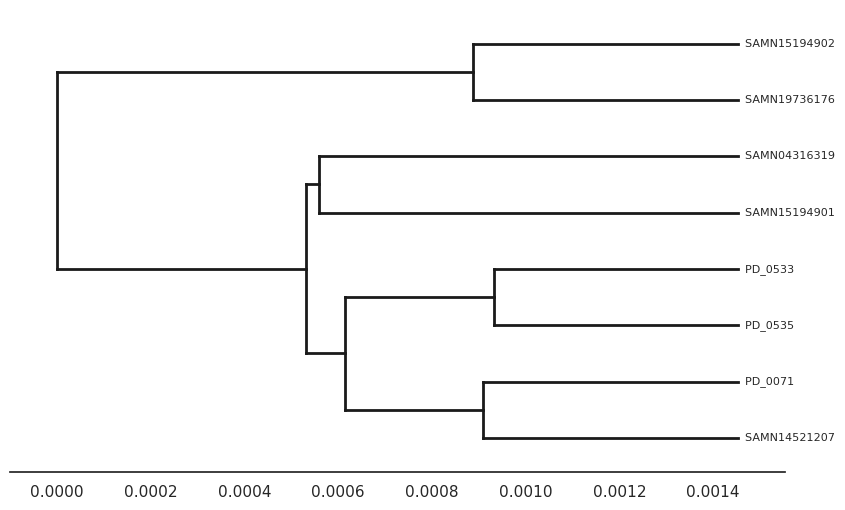

In [37]:
# Variation based on a gallery example
tree = bt.loadNewick("test_upgma.nwk")

tree.drawTree()
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim(-0.1,tree.ySpan+0.1)
ax.set_xlim(-0.0001,tree.treeHeight+0.0001)
ax.set_yticks([])
ax.set_yticklabels([])

target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: "  "+k.name ## what text is plotted. Added two spaces, x_attr somehow fails
kwargs={'va':'center','ha':'left','size': 8} ## kwargs for text

tree.addText(ax,target=target_func,text=text_func,**kwargs) ## text will use a different x attribute 


# Plot the tree
tree.plotTree(ax)
[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
plt.show()

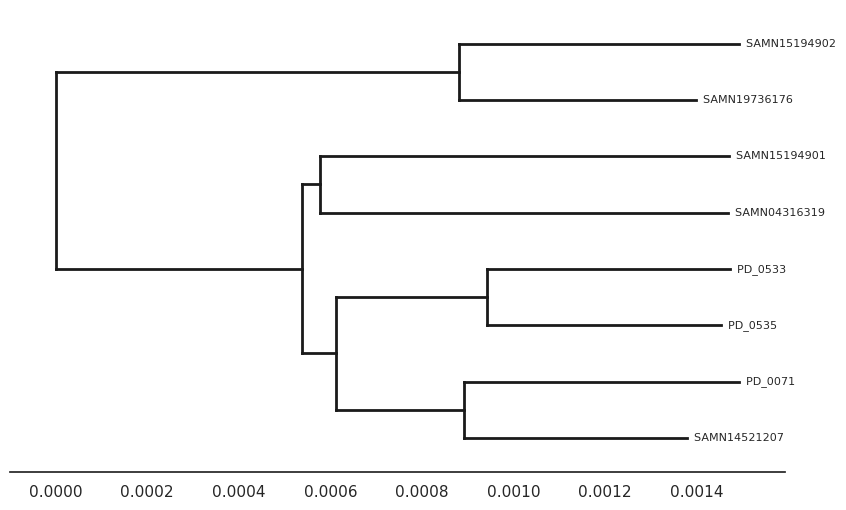

In [38]:
# Variation based on a gallery example
tree = bt.loadNewick("test_nj.nwk")

tree.drawTree()
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim(-0.1,tree.ySpan+0.1)
ax.set_xlim(-0.0001,tree.treeHeight+0.0001)
ax.set_yticks([])
ax.set_yticklabels([])

target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: "  "+k.name ## what text is plotted. Added two spaces, x_attr somehow fails
kwargs={'va':'center','ha':'left','size': 8} ## kwargs for text

tree.addText(ax,target=target_func,text=text_func,**kwargs) ## text will use a different x attribute 


# Plot the tree
tree.plotTree(ax)
[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
plt.show()

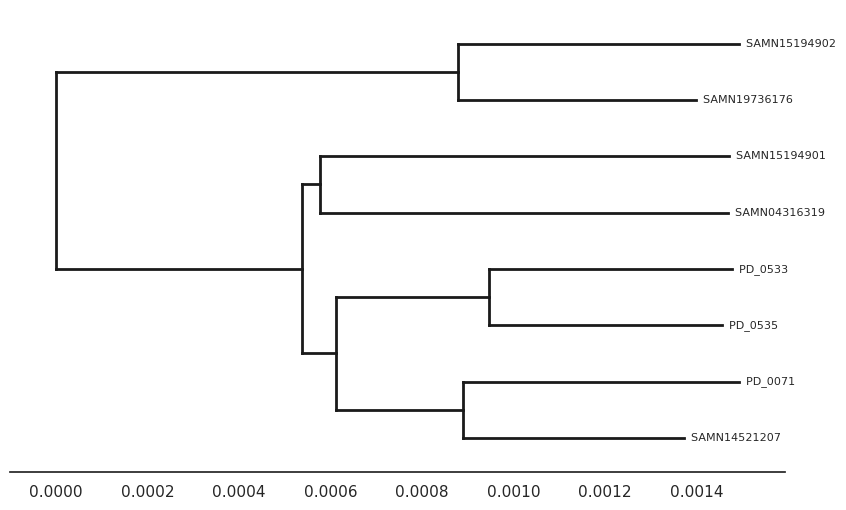

In [39]:
# Variation based on a gallery example
tree = bt.loadNewick("test_bme.nwk")

tree.drawTree()
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim(-0.1,tree.ySpan+0.1)
ax.set_xlim(-0.0001,tree.treeHeight+0.0001)
ax.set_yticks([])
ax.set_yticklabels([])

target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: "  "+k.name ## what text is plotted. Added two spaces, x_attr somehow fails
kwargs={'va':'center','ha':'left','size': 8} ## kwargs for text

tree.addText(ax,target=target_func,text=text_func,**kwargs) ## text will use a different x attribute 


# Plot the tree
tree.plotTree(ax)
[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
plt.show()

As we can see, there is a large difference between the UPGMA, NJ and bme trees.
Surprisingly, UPGMA is the most reasonable in distinguishing between the outgroup and the others. On the other hand, all is within-species, so clock-like structure is more likely than otherwise.

In [26]:
metadata_path = "~/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"
bed_base = "~/primatediversity/data/gVCFs_recalling_10_12_2024/"

path_list = ["../zarr_20x_inds/Macaca_arctoides_ssp/zarr"]

In [50]:
print("Loading metadata")
zarr_path = "../human_ref_zarr_20x_inds/Allenopithecus_nigroviridis_ssp/zarr"

ds_full = sg.load_dataset(zarr_path)
ds_full

Loading metadata


<xarray.Dataset> Size: 2GB
Dimensions:                             (variants: 6950871, samples: 3,
                                         alleles: 2, genotypes: 3,
                                         FORMAT_SB_dim: 4, alt_alleles: 1,
                                         ploidy: 2, contigs: 24, filters: 2,
                                         region_index_values: 30,
                                         region_index_fields: 6,
                                         INFO_RAW_MQandDP_dim: 2)
Dimensions without coordinates: variants, samples, alleles, genotypes,
                                FORMAT_SB_dim, alt_alleles, ploidy, contigs,
                                filters, region_index_values,
                                region_index_fields, INFO_RAW_MQandDP_dim
Data variables: (12/57)
    call_AD                             (variants, samples, alleles) int16 83MB dask.array<chunksize=(1000000, 3, 2), meta=np.ndarray>
    call_DP                             (variants, samples) int16 42MB dask.array<chunksize=(1000000, 3), meta=np.ndarray>
    call_GQ                             (variants, samples) int8 21MB dask.array<chunksize=(1000000, 3), meta=np.ndarray>
    call_PGT                            (variants, samples) object 167MB dask.array<chunksize=(1000000, 3), meta=np.ndarray>
    call_PID                            (variants, samples) object 167MB dask.array<chunksize=(1000000, 3), meta=np.ndarray>
    call_PL                             (variants, samples, genotypes) int16 125MB dask.array<chunksize=(1000000, 3, 3), meta=np.ndarray>
    ...                                  ...
    variant_filter                      (variants, filters) bool 14MB dask.array<chunksize=(1000000, 2), meta=np.ndarray>
    variant_id                          (variants) object 56MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    variant_id_mask                     (variants) bool 7MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    variant_length                      (variants) int8 7MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    variant_position                    (variants) int32 28MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    variant_quality                     (variants) float32 28MB dask.array<chunksize=(1000000,), meta=np.ndarray>
Attributes:
    source:                bio2zarr-0.1.6
    vcf_meta_information:  [['fileformat', 'VCFv4.2'], ['ALT', '<ID=NON_REF,D...
    vcf_zarr_version:      0.4

In [53]:
6950871/7984871

0.8705051089742089

In [51]:
print("Loading metadata")
zarr_path = "../zarr_20x_inds/Allenopithecus_nigroviridis_ssp/zarr"

ds_full = sg.load_dataset(zarr_path)
ds_full

Loading metadata


<xarray.Dataset> Size: 464MB
Dimensions:               (variants: 7984871, samples: 3, ploidy: 2,
                           contigs: 70286, filters: 2, region_index_values: 31,
                           region_index_fields: 6, alt_alleles: 1, alleles: 2)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alt_alleles, alleles
Data variables: (12/19)
    call_genotype         (variants, samples, ploidy) int8 48MB dask.array<chunksize=(1000000, 3, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 48MB dask.array<chunksize=(1000000, 3, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 24MB dask.array<chunksize=(1000000, 3), meta=np.ndarray>
    contig_id             (contigs) object 562kB dask.array<chunksize=(35143,), meta=np.ndarray>
    contig_length         (contigs) float64 562kB dask.array<chunksize=(35143,), meta=np.ndarray>
    filter_description    (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_filter        (variants, filters) bool 16MB dask.array<chunksize=(1000000, 2), meta=np.ndarray>
    variant_id            (variants) object 64MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 8MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    variant_length        (variants) int16 16MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    variant_position      (variants) int32 32MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    variant_quality       (variants) float32 32MB dask.array<chunksize=(1000000,), meta=np.ndarray>
Attributes:
    source:                bio2zarr-0.1.6
    vcf_meta_information:  [['fileformat', 'VCFv4.2'], ['ALT', '<ID=NON_REF,D...
    vcf_zarr_version:      0.4